In [30]:
import torch

from autoencoder import Autoencoder
import pandas
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from tqdm import tqdm
import os
from sklearn.decomposition import PCA
import datetime


#### Constants and definitions

In [31]:
print("Running directory:",os.getcwd())

# CONSTS
TEST_PURPOSE = False

USE_PCA = True
TRAIN_LSTM = False
EPOCHS = 100
scalers = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)

Running directory: /Users/igorvinokur/Development/Dev/Study/generative-model/py/model/autoencoder
Device: cpu


#### Reading data

In [32]:
DATA = pandas.read_csv('../../../rnn/merged.csv')
ANOMALY_DATA = pandas.read_csv('../../../rnn/merged_test.csv')

#### Data processing utils

In [33]:
def normalize_data(original_data):
    norm_data = original_data
    for i in original_data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(-1, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def unnormalize_data(columns, reconstructed_data):
    restored_data = []
    for (i, name) in enumerate(columns):
        restored_data.append(np.array(scalers['scaler_' + name].inverse_transform(reconstructed_data[:,i].reshape(-1, 1))).flatten())
    return np.array(restored_data)


def split_data(data, window):
    """
    Data split for train and labels with sliding window
    :param data: original data
    :param window: subsequence length
    :return:
    """
    train_x = data[:window + 1]
    x, y = sliding_windows(train_x, 1)
    train_x = Variable(torch.Tensor(np.array(x)))
    train_y = Variable(torch.Tensor(np.array(y)))
    return train_x, train_y


def sliding_windows(data, seq_length):
    """
    Sliding window transformation for the data
    :param data: original data
    :param seq_length: window size
    :return: two arrays of x and y
    """
    x = []
    y = []
    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

def ploy_data(norm_data, anomaly_norm_data, current_run_dir, title="Data"):
    fig, axs = plt.subplots(1, figsize=(10, 10))
    axs.scatter(norm_data[:,0], norm_data[:,1], label="Normal", color="g")
    axs.scatter(anomaly_norm_data[:,0], anomaly_norm_data[:,1], label="Anomaly", color="r")
    axs.set_title(title)
    axs.legend()
    plt.legend()
    plt.savefig(os.getcwd() + os.sep + 'res' + os.sep + current_run_dir + os.sep + title.replace("/", "_"))
    plt.show()
    plt.close()

def filter_column_indexs(columns, other_columns):
    filtered = []
    for c in other_columns:
        if c in columns:
            filtered.append(columns.index(c))
    return filtered

#### LSTM Train

In [34]:
def train(model, train_data, test_data, anomaly_norm_data, current_run_dir=None):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    objective = nn.MSELoss().to(device)
    history = []
    test_losses = []
    anomaly_losses = []
    for e in tqdm(range(EPOCHS)):
        model.train()
        loss = 0
        test_loss = 0
        anomaly_loss = 0
        for i in tqdm(range(len(train_data))):
            x = train_data[i]
            x = torch.Tensor(np.array([x])).to(device)
            optimizer.zero_grad()
            reconstructed = model(x)
            loss = objective(reconstructed, x)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            if i % 1000 == 0:
                print("\n========== \nEpoch: ", e, " Seq: ", i, "\n=============")
        history.append(loss.item())
        with torch.no_grad():
            model.eval()
            x = torch.Tensor(np.array([test_data])).to(device)
            reconstruction = model(x)
            test_loss = objective(reconstruction, x)
            test_losses.append(test_loss.item())
            # anomaly
            x = torch.Tensor(np.array([anomaly_norm_data])).to(device)
            reconstruction = model(x)
            anomaly_loss = objective(reconstruction, x)
            anomaly_losses.append(anomaly_loss.item())
        # if e % 10 == 0:
        torch.save(model.state_dict(), "res" + os.sep + current_run_dir + os.sep + "epoch_" + str(e) + ".model")
        print("================================")
        print('Epoch: ', e);
        print("Loss: ", loss.item())
        print("Test Loss: ", test_loss.item())
        print("Anomaly Loss: ", anomaly_loss.item())
        print("================================")
    return history, test_losses, anomaly_losses

def predict(model, dataset):
    predictions = []
    with torch.no_grad():
        model = model.eval()
        x = torch.Tensor(np.array([dataset])).to(device)
        reconstruction = model(x)
    return reconstruction.squeeze(0)


#### PCA

In [35]:
def use_pca(norm_data, DATA, n_components=0.90):
    pca = PCA(n_components=n_components)
    pca.fit_transform(norm_data)
    n_pcs = pca.n_components_
    most_important = [[np.abs(pca.components_[i]).argmax(), pca.components_[i].max()] for i in range(n_pcs)]
    most_important = sorted(most_important , key=lambda a_entry: -a_entry[1])
    initial_feature_names = DATA.columns
    most_important_column_names = [initial_feature_names[most_important[i][0]] for i in range(n_pcs)]
    print('Most important columns number ', len(most_important_column_names))
    print('Most important columns', most_important_column_names)
    NEW_DATA = norm_data[most_important_column_names].values
    return NEW_DATA, most_important_column_names

In [36]:
def main():
    current_run_dir = datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")
    os.mkdir(os.getcwd() + os.sep + 'res' + os.sep + current_run_dir)
    norm_data, columns = DATA.values, DATA.columns
    n_features = len(columns)
    if USE_PCA:
        norm_data, columns = use_pca(normalize_data(DATA.copy()), DATA)
        n_features = len(columns)
    else:
        norm_data, columns = normalize_data(DATA.copy()).values, list(DATA.columns.values)
        n_features = len(DATA.columns)

    anomaly_columns = ANOMALY_DATA.columns
    # find intersected columns
    inter_columns = np.intersect1d(columns, anomaly_columns)
    inter_columns = [x for _, x in sorted(zip(columns, inter_columns), key=lambda pair: pair[0])]
    anomaly_norm_data = normalize_data(ANOMALY_DATA.copy())[inter_columns].values
    # take only data with intersected columns
    filtered_index = filter_column_indexs(columns, inter_columns)
    norm_data = norm_data[:, filtered_index]
    columns = inter_columns

    for i in range(len(norm_data[0]) - 2):
        nd = norm_data[:, i:i+2]
        a_nd = anomaly_norm_data[:, i:i+2]
        c = ', '.join(columns[i:i+2])
        ploy_data(nd, a_nd, current_run_dir, c)

    norm_data = norm_data[:, :2]
    columns = columns[:2]
    anomaly_norm_data = anomaly_norm_data[:, :2]
    n_features = len(columns)
    print(n_features)
    ploy_data(norm_data, anomaly_norm_data, current_run_dir, ', '.join(columns))


    if TEST_PURPOSE:
        norm_data = norm_data[:200]

    if not TRAIN_LSTM:
        return
    
    lstm_stacks = 2
    autoencoder_input = n_features
    encoder_hidden_layers = int(n_features/2)
    decoder_input = n_features
    seq_len = 60
    autoencoder_output = n_features
    
    autoencoder = Autoencoder(lstm_stacks,
                              autoencoder_input,
                              encoder_hidden_layers,
                              decoder_input,
                              seq_len,
                              autoencoder_output).to(device)
    train_size = np.int(len(norm_data) * 0.8)
    train_data, test_data = norm_data[:train_size], norm_data[train_size:]
    train_x, train_y = sliding_windows(train_data, seq_len)
    h, l, a = train(autoencoder, train_x, test_data, anomaly_norm_data, current_run_dir)
    
    print(h)
    print(l)
    fig, axs = plt.subplots(1)
    
    axs.plot(range(len(h)), h, label="Train loss")
    axs.plot(range(len(l)), l, label="Test loss")
    axs.plot(range(len(a)), a, label="Anomaly loss")
    axs.set_title('Losses')
    axs.legend()
    plt.legend()
    plt.savefig(os.getcwd() + os.sep + 'res' + os.sep + current_run_dir + os.sep + 'train_test')
    plt.show()
    plt.close()
    torch.save(autoencoder.state_dict(), "res" + os.sep + current_run_dir + os.sep + "final.model")
    reconstruction = predict(autoencoder, test_data)
    reconstruction = unnormalize_data(columns, reconstruction.cpu().numpy())
    
    original = DATA[columns].values[:len(test_data)]
    for i in range(len(reconstruction)):
        plt.figure(figsize=(30, 10))
        plt.plot(range(len(reconstruction[i])), reconstruction[i], label="Reconstructed " + columns[i])
        plt.plot(range(len(original[:,i])), original[:,i], label="Original " + columns[i])
        plt.legend()
        plt.show()
        plt.savefig(os.getcwd() + os.sep + 'res' + os.sep + current_run_dir + os.sep + str(i))
        plt.close()
    
    file = open(os.getcwd() + os.sep + 'res' + os.sep + current_run_dir + os.sep + 'model_params.txt', "w+")
    file.writelines([
        'lstm_stacks='+str(lstm_stacks),
        '\n\rautoencoder_input='+str(autoencoder_input),
        '\n\rencoder_hidden_layers='+str(encoder_hidden_layers),
        '\n\rdecoder_input='+str(decoder_input),
        '\n\rseq_len='+str(seq_len),
        '\n\rautoencoder_output=' + str(autoencoder_output)
    ])
    file.close()

## Run training and test

Most important columns number  13
Most important columns ['MeanLoadCPU(/twist_mux)', 'Mean_Consecutive(/particlecloud)', 'Counter(/particlecloud)', 'Mean_Consecutive(/move_base/local_costmap/costmap_updates)', 'Mean_Consecutive(/move_base/TebLocalPlannerROS/teb_markers)', 'Mean_Consecutive(/host_diagnostic)', 'Mean_Consecutive(/move_base/local_costmap/costmap)', 'linear velocity x', 'Mean_Consecutive(/particlecloud)', 'linear velocity x', 'Mean_Consecutive(/host_diagnostic)', 'Mean_Consecutive(/move_base/local_costmap/costmap)', 'MeanLoadCPU(/amcl)']


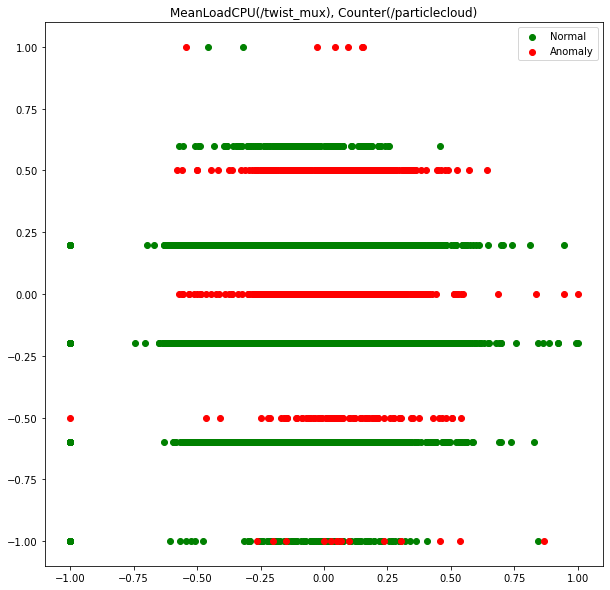

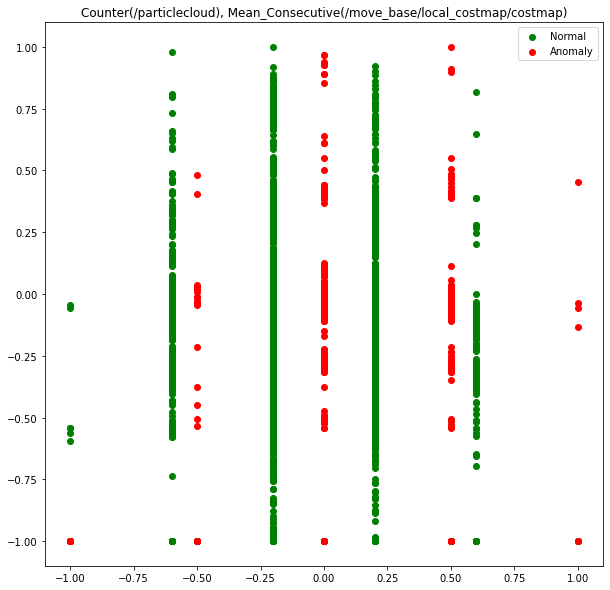

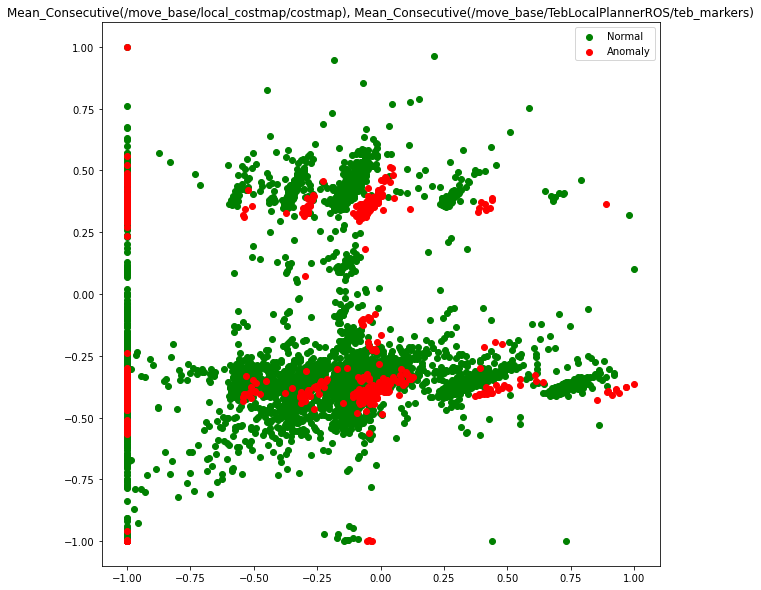

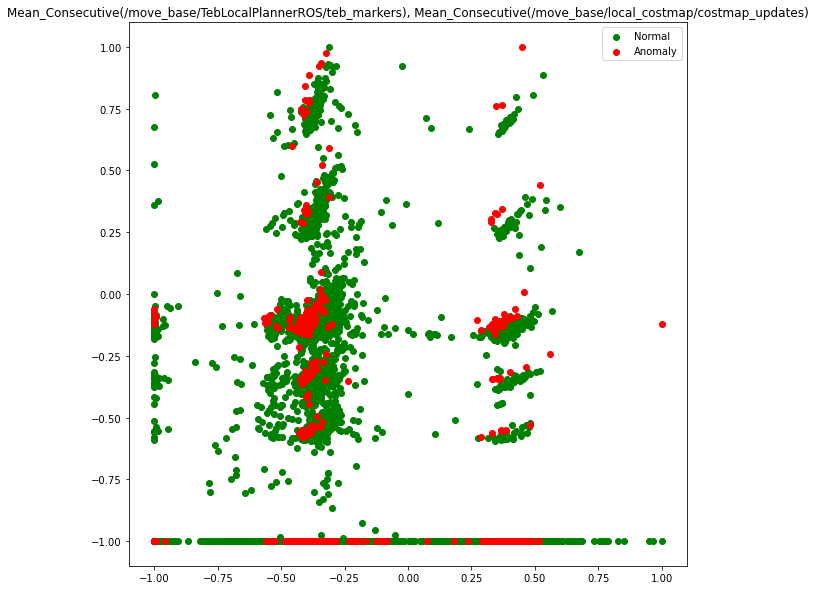

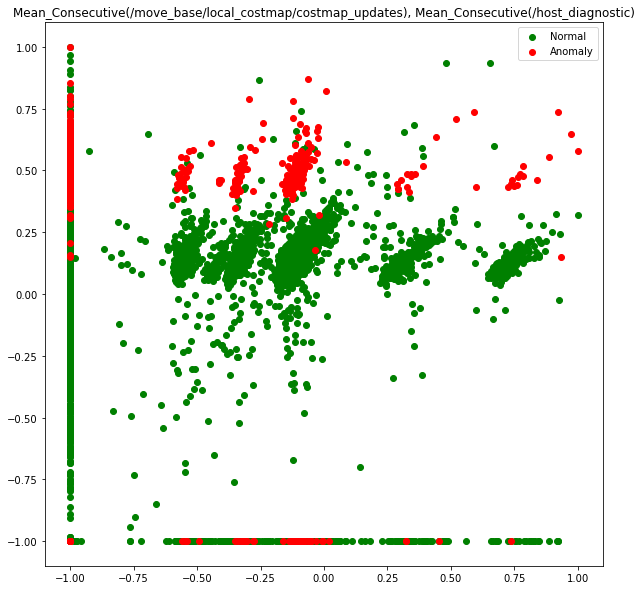

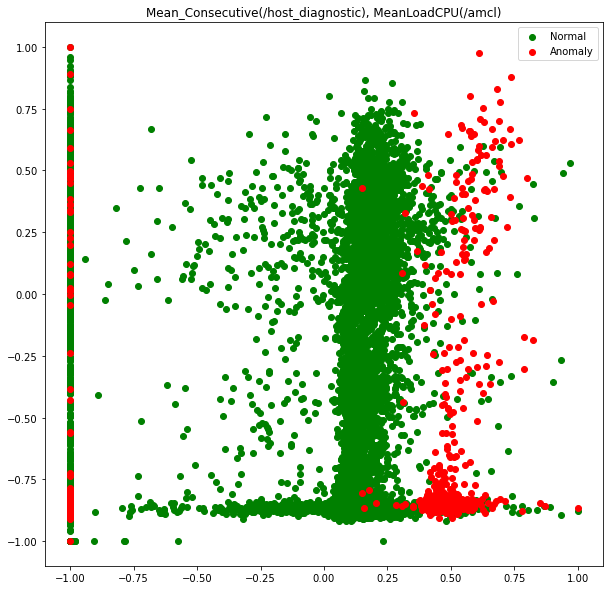

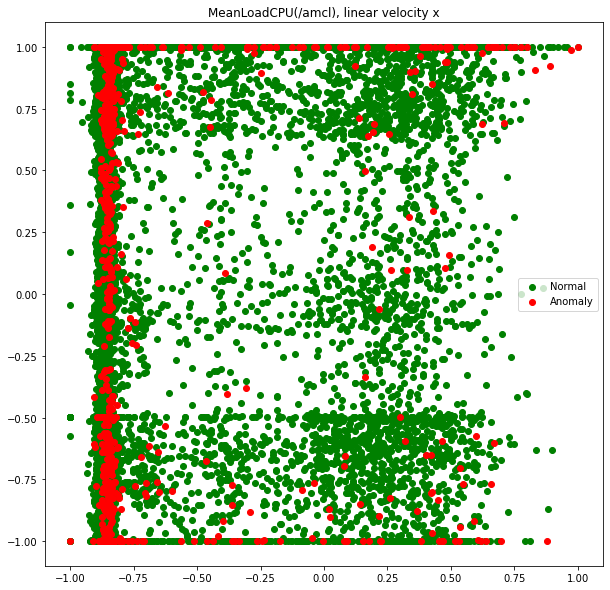

2


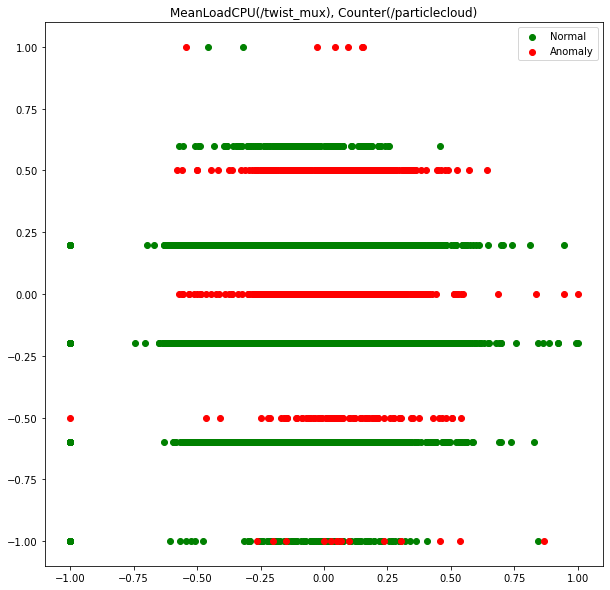

In [37]:
main()

#### Experiments with data

[[60, 0.8090354841552833], [56, 0.7691385064978156], [58, 0.7436562652808525], [51, 0.701092310436617], [50, 0.6896673366538126], [33, 0.6493729261873946], [23, 0.6384592392618232], [56, 0.6249880869930816], [31, 0.623117720730697], [3, 0.5573138559465179], [3, 0.4938368972500471], [31, 0.46423472005857325], [51, 0.42838925566529445]]


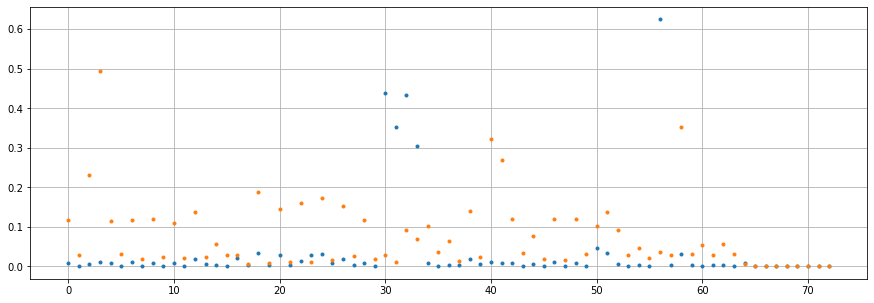

['MeanLoadCPU(/twist_mux)', 'linear velocity x', 'MeanLoadCPU(/amcl)', 'Mean_Consecutive(/particlecloud)', 'Counter(/particlecloud)', 'Mean_Consecutive(/move_base/local_costmap/costmap_updates)', 'Mean_Consecutive(/move_base/TebLocalPlannerROS/teb_markers)', 'linear velocity x', 'Mean_Consecutive(/move_base/local_costmap/costmap)', 'Mean_Consecutive(/host_diagnostic)', 'Mean_Consecutive(/host_diagnostic)', 'Mean_Consecutive(/move_base/local_costmap/costmap)', 'Mean_Consecutive(/particlecloud)']


In [70]:
norm_data = normalize_data(DATA.copy())
pca = PCA(n_components=0.9)
new_data = pca.fit_transform(norm_data)
n_pcs = pca.n_components_
most_important = [[np.abs(pca.components_[i]).argmax(), np.abs(pca.components_[i]).max()] for i in range(n_pcs)]
most_important = sorted(most_important , key=lambda a_entry: -a_entry[1])
print(most_important)
two_cols = pca.components_[:2, :]
fig, axs = plt.subplots(1, figsize=(15, 5))
axs.plot(abs(two_cols.T), ".")
plt.grid()
plt.show()
plt.close()

initial_feature_names = DATA.columns
most_important_column_names = [initial_feature_names[most_important[i][0]] for i in range(n_pcs)]
print(most_important_column_names)

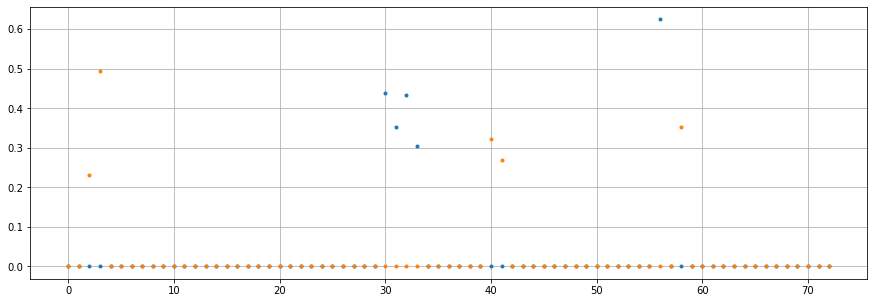

In [71]:
pca_comp = two_cols
pca_comp = np.where(abs(pca_comp) <= 0.2, 0, pca_comp)
fig, axs = plt.subplots(1, figsize=(15, 5))
axs.plot(abs(pca_comp.T), ".")
plt.grid()
plt.show()
plt.close()


$x = [x_1, x_2,...,x_{73}]\\$
$a = [0,0,0,..,a_n,0,..,a_k,0,...a_m,0...]\\\\
\tilde{y} = x \cdot a$

(17875, 2)


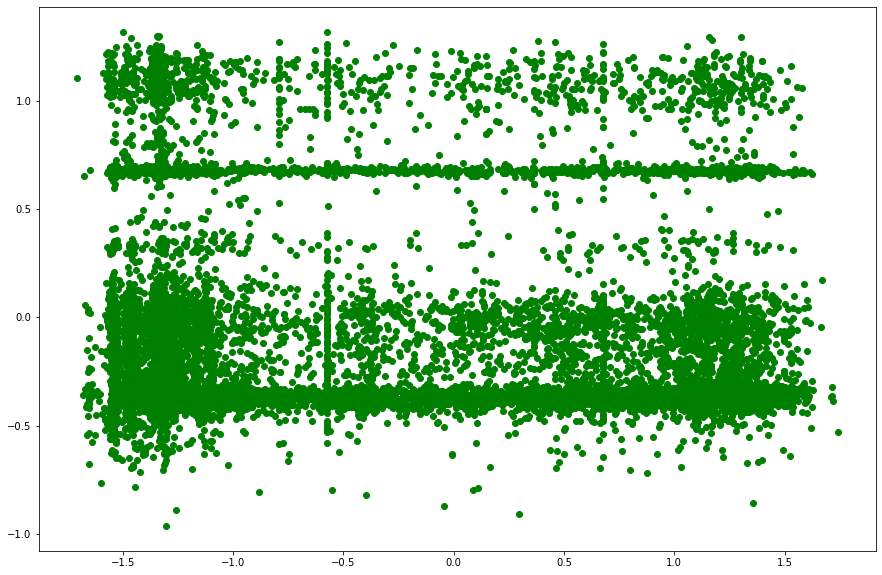

In [74]:
fig, axs = plt.subplots(1, figsize=(15, 10))
pca_d = pca_comp.dot(norm_data.T).T
print(pca_d.shape)
axs.scatter(pca_d[:,0], pca_d[:,1], color="g")